In [1]:
import dpkt
import os
import struct
import numpy as np
from collections import defaultdict
from pprint import pprint

try:
    from Memoizer import memoize_to_folder
    memoize = memoize_to_folder("e2e_memoization")
except:
    # In case Memoizer isn't present, this decorator will just do nothing
    memoize = lambda x : x

In [2]:
KEYLEN=8

def read_pcap(out_dir, dst_mac_is_ts = True, try_compare_counters = True):

    counters = {
        'set': 0,
        'miss': 0,
        'get': 0,
        'value': 0,
        'unreach': 0,
        'other': 0,
        'stored': 0
    }
    
    gets = defaultdict(list)
    vals = defaultdict(list)
    sets = defaultdict(list)
    storeds = defaultdict(list)
    misses = []
    
               
    pcfs = [os.path.join(out_dir, 'pcap_dump', 'mcd_c_to_tofino1.pcap'),
            os.path.join(out_dir, 'pcap_dump', 'tofino1_to_mcd_c.pcap'),]
    
    for pcf in pcfs:

        f = open(pcf, 'rb')
        print("Reading {}".format(pcf))
        pcap=dpkt.pcap.Reader(f)
        total_size = 0
        start_ts = None
        for i, (ts, buf) in enumerate(pcap):
            try:
                eth=dpkt.ethernet.Ethernet(buf)
                ip=eth.data
                if type(ip) != dpkt.ip.IP:
                    counters['other'] += 1
                    continue
                udp = ip.data
                spkt = udp.data
            except Exception as e:
                print("Exception parsing packet {} : {}".format(buf, e))
                Ether(buf).show2()
                raise

            if start_ts is None:
                start_ts = ts
            ts -= start_ts

            if type(spkt) == dpkt.icmp.ICMP.Unreach:
                counters['unreach'] += 1
                continue

            get_start = spkt.find(b'get ')
            if get_start >= 0:
                key = spkt[:2] + spkt[get_start+4:get_start+4+KEYLEN]
                gets[key].append(ts)
                counters['get'] += 1
                continue
            val_start = spkt.find(b'VALUE ')
            if val_start >= 0:
                key = spkt[:2] + spkt[val_start+6:val_start+6+KEYLEN]
                vals[key].append((ts, ip.id))
                counters['value'] += 1
                total_size += udp.ulen + 44
                continue
            if b'set ' in spkt:
                key = spkt[:2]
                sets[key].append(ts)
                counters['set'] += 1
            elif b'STORED' in spkt:
                key = spkt[:2]
                storeds[key].append((ts, ip.id))
                counters['stored'] += 1
                total_size += udp.ulen + 44
                continue
            elif b'END' in spkt:
                counters['miss'] += 1
                total_size += udp.ulen + 44
                misses.append(ts)
            else:
                counters['other'] += 1
                print('Unknown packet load: {}'.format(buf))
            
    print("Finished reading pcap: ")
    pprint(counters)
    
    return gets, vals, sets, storeds, total_size, misses, counters

In [3]:
import itertools
  
def calculate_success(reqs, resps, start, end, extra_resps = {}, interval = 2):
    starts = np.arange(start, end, interval)
    ends = np.arange(start + interval, end + interval, interval)
    
    n_reqs = [0. for _ in starts]
    n_resp = [0. for _ in starts]    
    
    for k, v in reqs.items():
        for time in v:
            idx = np.nonzero((time >= starts) & (time < ends))
            if len(idx[0]) == 0:
                continue
            if len(idx[0]) != 1:
                print("WEIRD!")
            n_reqs[idx[0][0]] += 1
            
            if k in resps:
                n_resp[idx[0][0]] += float(len(resps[k])) / len(v)
        
    return  np.array(n_resp) / np.array(n_reqs)
    
    
def calculate_tds(reqs, resps, hits_only = False, misses_only = False):
    print("Getting TDs")
    
    req_keys = set(reqs.keys())
    resp_keys = set(resps.keys())
    
    missing_resps = 0
    for k in req_keys - resp_keys:
        missing_resps += len(reqs[k])
    
    missing_reqs = 0
    for k in resp_keys - req_keys:
        missing_reqs += len(resps[k])
    
    mismatched_length_reqs = 0
    mismatched_length_resps = 0
    tds = []
    
    for k in req_keys & resp_keys:
        
        resp = resps[k]
        mask = (np.ones(len(resp)) == 1)
        
        if misses_only:
            mask &= np.array([v[1] != 1 for v in resp])
        if hits_only:
            mask &= np.array([v[1] == 1 for v in resp])
            
        resp_times = np.array([v[0] for v in resp])
        req_times = np.array(reqs[k])
        
        lendiff = len(resp_times) - len(req_times)
        if lendiff != 0:
            mismatched_length_resps += len(resp_times)
            mismatched_length_reqs += len(req_times)
            continue
            
        new_tds = resp_times[mask] - req_times[mask]
        tds.extend([gt, td] for gt, td in zip(req_times[mask], new_tds))
        
    print("Missing {} requests".format(missing_reqs))
    print("Discarded {} requests".format(mismatched_length_reqs))
    print("Missing {} responses".format(missing_resps))
    print("Discarded {} responses".format(mismatched_length_resps))
    print("\n*** Got {} Latencies ***\n".format(len(tds)))
    
    return np.array(tds)

def experiment_success_rate(directory):
    _, _, _, _, _, _, counters = read_pcap(directory)
    return (counters['value'] + counters['miss']) * 100.0 / counters['get'], \
           (counters['stored'] * 100.0) / counters['set']
    
    return get_success_percent(gets, vals), get_success_percent(sets, storeds)

@memoize
def experiment_tds(directory, start, end):
    gets, vals, sets, storeds, total_length, misses, _ = read_pcap(directory)
    get_succ = calculate_success(gets, vals, start, end, misses)
    set_succ = calculate_success(sets, storeds, start, end)
    
    get_tds = calculate_tds(gets, vals)
    set_tds = calculate_tds(sets, storeds)
    
    print(get_tds[:,0].max(), get_tds[:,0].min())
    print(set_tds[:,0].max(), set_tds[:,0].min())
    
    get_tds = get_tds[(get_tds[:,0] > start) & (get_tds[:,0] < end)]
    set_tds = set_tds[(set_tds[:,0] > start) & (set_tds[:,0] < end)]
    
    return get_tds, set_tds, get_succ, set_succ

In [4]:
import json
from glob import glob

DIV = 1e6

def lenient_read_json(file):
    try:
        return json.load(open(file))
    except Exception as e:
        print("Malformed json {}: {}".format(file, e))
        lines = '\n'.join(open(file).readlines()[1:])
        return json.loads(lines)


def read_iperf_ts_directory(directory):

    client_file = os.path.join(directory,'log_files','iperf_c_prog_5.log')

    client = lenient_read_json(client_file)
    client_bps = []
    
    for interval in client['intervals']:
        interval = interval['sum']
        client_bps.append(interval['bits_per_second'])

    summed_bps = np.array(client_bps)
    print(np.mean(summed_bps) / DIV)
    
    return summed_bps / DIV


In [5]:
MCD_START = 30
MCD_END = 60

def aggregate_iperf_data(experiments):
    y = []
    
    for exp in experiments:
        print(exp)
        y.append(read_iperf_ts_directory(exp))         
    return y

def aggregate_mcd_data(experiments):
    y = []
    
    for exp in experiments:
        gets, sets, _, _ = experiment_tds(exp, MCD_START, MCD_END)
        all_tds = np.array([[], []]).T
        all_tds = np.append(all_tds, gets, 0)
        all_tds = np.append(all_tds, sets, 0)
        y.append(all_tds)
    return y

def aggregate_more_mcd_data(experiments):
    y = defaultdict(list)
    
    for exp in experiments:
        gets, sets, get_succ, set_succ = experiment_tds(exp, MCD_START, MCD_END)

        y['get'].append(gets)
        y['set'].append(sets)
        y['get_s'].append(get_succ)
        y['set_s'].append(set_succ)
        
    return y

In [7]:
from collections import OrderedDict

base_dir = '../bmv2//test_output/tclust_e2e_bw_none_tclust_'
experiments = ['noop', 'compression', 'drop_compression', 'fec_and_hc', 'complete']
exp_dirs = [base_dir + e for e in experiments]
exp_dirs

['../bmv2//test_output/tclust_e2e_bw_none_tclust_noop',
 '../bmv2//test_output/tclust_e2e_bw_none_tclust_compression',
 '../bmv2//test_output/tclust_e2e_bw_none_tclust_drop_compression',
 '../bmv2//test_output/tclust_e2e_bw_none_tclust_fec_and_hc',
 '../bmv2//test_output/tclust_e2e_bw_none_tclust_complete']

In [8]:
iperf_data = aggregate_iperf_data(exp_dirs)

../bmv2//test_output/tclust_e2e_bw_none_tclust_noop
11.718437453594712
../bmv2//test_output/tclust_e2e_bw_none_tclust_compression
7.028755336887826
../bmv2//test_output/tclust_e2e_bw_none_tclust_drop_compression
4.054542188647175
../bmv2//test_output/tclust_e2e_bw_none_tclust_fec_and_hc
5.0292765409882385
../bmv2//test_output/tclust_e2e_bw_none_tclust_complete
5.255299900687825


In [9]:
more_mcd_data = aggregate_more_mcd_data(exp_dirs)
for i in range(len(experiments)):
    more_mcd_data['get_s'][i] *= 100
    more_mcd_data['set_s'][i] *= 100


Reading ../bmv2//test_output/tclust_e2e_bw_none_tclust_noop/pcap_dump/mcd_c_to_tofino1.pcap
Reading ../bmv2//test_output/tclust_e2e_bw_none_tclust_noop/pcap_dump/tofino1_to_mcd_c.pcap
Finished reading pcap: 
{'get': 4500,
 'miss': 0,
 'other': 0,
 'set': 3746,
 'stored': 3741,
 'unreach': 77,
 'value': 4442}
Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 58 responses
Discarded 0 responses

*** Got 4442 Latencies ***

Getting TDs
Missing 0 requests
Discarded 3 requests
Missing 4 responses
Discarded 2 responses

*** Got 3739 Latencies ***

(71.95188117027283, 21.971970081329346)
(71.96188116073608, 0.0)
Reading ../bmv2//test_output/tclust_e2e_bw_none_tclust_compression/pcap_dump/mcd_c_to_tofino1.pcap
Reading ../bmv2//test_output/tclust_e2e_bw_none_tclust_compression/pcap_dump/tofino1_to_mcd_c.pcap
Finished reading pcap: 
{'get': 4500,
 'miss': 0,
 'other': 0,
 'set': 3800,
 'stored': 3793,
 'unreach': 77,
 'value': 4442}
Getting TDs
Missing 0 requests
Discarded 0 requests
Mi

In [10]:
import matplotlib.pyplot as plt
BOX_WIDTH = .5

def boxplot(ax, data, pos, facecolor, linecolor, textfile, labels, width=BOX_WIDTH * .8, line='-'):
    pl = ax.plot(pos, [np.median(y) for y in data], line, color=facecolor, linewidth=2, zorder=1)
    bp = ax.boxplot(data, positions=pos, widths=width,showfliers=False, patch_artist=True, whis=[10,90], boxprops=dict(facecolor=facecolor), whiskerprops=dict(linewidth=2),medianprops=dict(color=linecolor), zorder=10)
    plt.xticks(np.arange(len(pos)))
    ax.set_xticklabels(labels, fontsize=14)
    if textfile:
        with open(textfile,'w') as f:
            f.write("ft.\t10%\t25%\t50%\t75%\t90%\n")
            for x, y in zip(mcdx, data):
                f.write("{}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\n"
                        .format(x, *[np.percentile(y, p) for p in [10,25,50,75,90]]))
    return pl

def make_iperf_boxplot(labels, y, ax, color_labels=True, textfile=None, width=BOX_WIDTH, offset = BOX_WIDTH/2.5):
    x = np.arange(len(labels)) + offset
    
    print(len(x), len(y))
    c = 'r'
    
    parts = boxplot(ax, y, x, c, [1,1,0], textfile, labels, line='--', width=width)

    ax.legend(parts, ['Iperf Throughput'],loc='upper right')
  
    ax.set_ylabel('Throughput (Mbps)', color=c if color_labels else 'k')
    ax.set_yscale('linear')
    
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    
    if color_labels:
        plt.setp(ax.get_yticklabels(), color=c)
        ax.tick_params(axis='y', colors=c)
        ax.spines['right'].set_color(c)
        
        
    plt.xlim([-.5, 4.5])
             
    return parts


def make_mcd_boxplot(labels, data, ax, color_labels=True, textfile=None, 
                     color = None, width=BOX_WIDTH, offset = -BOX_WIDTH/2.5,
                     legend = 'Cache Latency'):
    pos = np.arange(len(labels)) + offset
    
    try:
        y = [d[:,1] for d in data]
    except:
        y = data
            

    if color is not None:
        c = color
    else:
        c = 'b'
    parts = boxplot(ax, y, pos,c, [.7,.9,.7], textfile, labels, width=width)

    ax.legend(parts, [legend], loc='lower left')
    
    ax.set_ylabel(r"Latency ($s$)", color=c if color_labels else 'k')
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    if color_labels:
        plt.setp(ax.get_yticklabels(), color=c)
        ax.tick_params(axis='y', colors=c)
        ax.spines['left'].set_color(c)
#     ax.set_yscale('log')
    
    plt.xlim([-.5, 4.5])
    
    return parts


In [11]:
def make_figure(experiments, iperf_data, more_mcd_data):
    plt.figure()
    ax= plt.subplot(311)
    s = make_iperf_boxplot(experiments, iperf_data, ax, width=.5, offset = 0)

    for x in .5, 1.5, 2.5, 3.5:
        ax.axvline(x, color=[.2,.2,.2], linewidth=.5)

    ax.set_xticks([])   
    ax.legend(s, ['iperf Throughput'], loc=(.57, .7))

    ax= plt.subplot(312)
    s = make_mcd_boxplot(experiments, more_mcd_data['set'], ax, color='green', width=.3, offset = -.15)
    g = make_mcd_boxplot(experiments, more_mcd_data['get'], ax, width=.3, offset = .15)
    # plt.yscale('linear')

    for x in .5, 1.5, 2.5, 3.5:
        ax.axvline(x, color=[.2,.2,.2], linewidth=.5)

    ax.set_xticks([])

    ax.legend(g+s, ['Get latency', 'Set Latency'], loc=(.6, .6))
    ax= plt.subplot(313)

    s = make_mcd_boxplot(experiments, more_mcd_data['set_s'], ax, color='green', width=.3, offset = -.15)
    g = make_mcd_boxplot(experiments, more_mcd_data['get_s'], ax, width=.3, offset = .3)


    for x in .5, 1.5, 2.5, 3.5:
        ax.axvline(x, color=[.2,.2,.2], linewidth=.5)

    ax.legend(g+s, ['Get Success', 'Set Success'], loc=(.2, .2))
    plt.yscale('linear')
    plt.ylabel("Success (%)")

    plt.tight_layout(h_pad=-.2)
    # plt.yscale('linear')
    

<IPython.core.display.Javascript object>


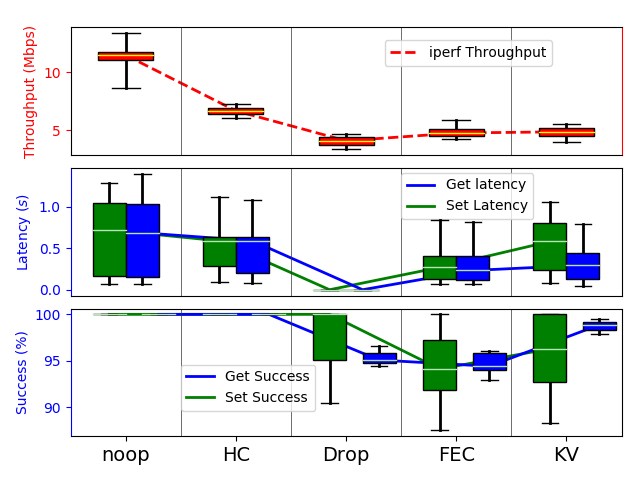

(5, 5)


In [12]:
%matplotlib notebook
make_figure(['noop', 'HC', 'Drop', 'FEC', "KV"], iperf_data, more_mcd_data)